## Fine-tuning CNN models for semantic segmentation 

In [1]:
import os
import time

import random
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.utils.data
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split

import torchvision
from torchvision import datasets, transforms
import torchvision.models as models

import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

In [2]:
root = os.getcwd()

### Load Data

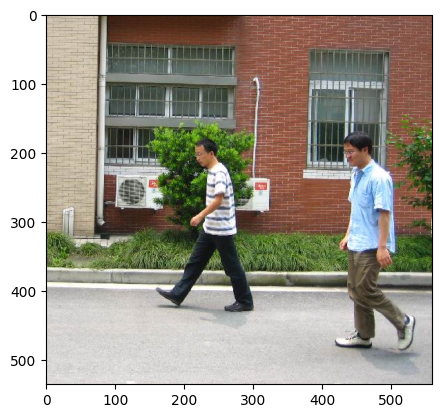

In [3]:
# Check one image and its mask.
image = Image.open(os.path.join(root,'data/PennFudanPed/PNGImages/FudanPed00001.png'))
plt.imshow(image);

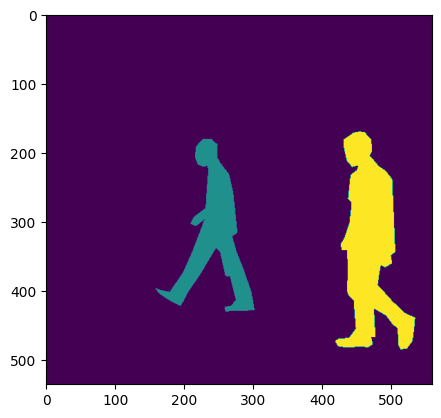

In [5]:
mask = Image.open(os.path.join(root,'data/PennFudanPed/PedMasks/FudanPed00001_mask.png'))
plt.imshow(mask);

### Preprocess

In [6]:
class PennFudanDataset(torch.utils.data.Dataset):
    def __init__(self, root, transforms=None, mode='detection'):
        self.root = root
        self.transforms = transforms
        # Load all image files, sorting them to ensure that they are aligned. 
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))
        
        self.mode = mode
        
        if not (self.mode == 'detection' or self.mode == 'segmentation'):
            raise ValueError(f"mode {self.mode} is not supproted")
        
    def __getitem__(self, idx):
        # Load images ad masks.
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        # Note that we haven't converted the mask to RGB,
        # because each color corresponds to a different instance with 0 being background.
        mask = Image.open(mask_path)

        mask = np.array(mask)
        
        if self.mode == 'detection':
            # Instances are encoded as different colors.
            obj_ids = np.unique(mask)
            # First id is the background, so remove it.
            obj_ids = obj_ids[1:]

            # Split the color-encoded mask into a set of binary masks.
            masks = mask == obj_ids[:, None, None]

            # Get bounding box coordinates for each masks.
            num_objs = len(obj_ids)
            boxes = []
            for i in range(num_objs):
                pos = np.where(masks[i])
                xmin = np.min(pos[1])
                xmax = np.max(pos[1])
                ymin = np.min(pos[0])
                ymax = np.max(pos[0])
                boxes.append([xmin, ymin, xmax, ymax])

            boxes = torch.as_tensor(boxes, dtype=torch.float32)
            # There is only one class.
            labels = torch.ones((num_objs,), dtype=torch.int64)

            image_id = torch.tensor([idx])
            area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
            # Suppose that all instances are not crowd.
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

            target = {}
            target["boxes"] = boxes
            target["labels"] = labels
            target["image_id"] = image_id
            target["area"] = area
            target["iscrowd"] = iscrowd

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target
        
        
        elif self.mode == 'segmentation':
            mask[mask > 0] = 1

            # There is only one class.
            mask = torch.as_tensor(mask, dtype=torch.uint8)

            image_id = torch.tensor([idx])

            target = {}
            target["masks"] = mask
            target["image_id"] = image_id

            if self.transforms is not None:
                img, target = self.transforms(img, target)

            return img, target

    def __len__(self):
        return len(self.imgs)

In [8]:
# Transform datasets
class RandomHorizontalFlip(object):
    def __init__(self, prob):
        self.prob = prob

    def __call__(self, image, target):
        if random.random() < self.prob:
            height, width = image.shape[-2:]
            image = image.flip(-1)
            if "boxes" in target:
                bbox = target["boxes"]
                bbox[:, [0, 2]] = width - bbox[:, [2, 0]]
                target["boxes"] = bbox
            if "masks" in target:
                target["masks"] = target["masks"].flip(-1)
            if "keypoints" in target:
                keypoints = target["keypoints"]
                keypoints = _flip_coco_person_keypoints(keypoints, width)
                target["keypoints"] = keypoints
        return image, target


class ToTensor(object):
    def __call__(self, image, target):
        image = transforms.ToTensor()(image)
        return image, target

class Resize(object):
    def __init__(self, size):
        self.size = size
    def __call__(self, image, target):
        image = transforms.Resize(self.size)(image)
        if "masks" in target:
            target["masks"] = transforms.Resize(self.size)(target["masks"].unsqueeze(dim=0)).squeeze()
        return image, target

class Normalize(object):
    def __call__(self, image, target):
        image = transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))(image)
        return image, target

class Compose(object):
    def __init__(self, transforms):
        self.transforms = transforms

    def __call__(self, image, target):
        for t in self.transforms:
            image, target = t(image, target)
        return image, target

In [9]:
def get_transform(train):
    transforms = [ToTensor(), Resize((300,300)), Normalize()]
    if train:
        transforms.append(RandomHorizontalFlip(0.5))
    return Compose(transforms)

### Pretrained Model: ResNet-50

In [10]:
# Load the pretrained ResNet model and check the structure.
seg_model = models.segmentation.fcn_resnet50(pretrained=True)
seg_model

Downloading: "https://download.pytorch.org/models/fcn_resnet50_coco-1167a1af.pth" to C:\Users\yulimy/.cache\torch\hub\checkpoints\fcn_resnet50_coco-1167a1af.pth


  0%|          | 0.00/135M [00:00<?, ?B/s]

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### Inference Test

In [11]:
image = Image.open(os.path.join(root,'data/PennFudanPed/PNGImages/FudanPed00001.png'))
mask = Image.open(os.path.join(root,'data/PennFudanPed/PedMasks/FudanPed00001_mask.png'))

# Convert image data to tensor
infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image)

output = seg_model(input_image.unsqueeze(dim=0))
output['out'][0].shape

torch.Size([21, 536, 559])

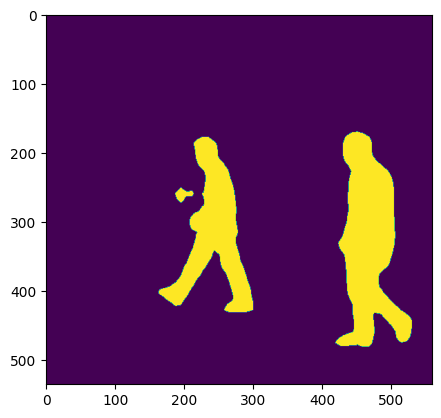

In [12]:
cls = torch.argmax(output['out'][0], dim=0).numpy()
out = np.zeros_like(cls)
out[cls==15] = 1
plt.imshow(out);

### Split tha Dataset

In [17]:
dataset_segmentation = PennFudanDataset(os.path.join(root,'data/PennFudanPed/'), get_transform(train=True),mode='segmentation')

random_seed = 0
torch.manual_seed(random_seed)

val_size = int(len(dataset_segmentation) * 0.2)
train_size = len(dataset_segmentation) - val_size

train_dataset, valid_dataset = random_split(dataset_segmentation, [train_size, val_size])
print(len(train_dataset), len(valid_dataset))

136 34


In [18]:
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False, drop_last=True)

### Fine-Tuning the model 

: Change the number of class of the last output.

In [13]:
seg_model.classifier[4] = nn.Conv2d(512, 2, kernel_size=(1,1), stride=(1,1))
seg_model

FCN(
  (backbone): IntermediateLayerGetter(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequenti

### Train the model

In [14]:
## Trainer class 정의

class Semantic_Seg_Trainer(nn.Module):
    def __init__(self, model,opt="adam", lr=0.001, has_scheduler=False, device="cpu"):
        """
        Args:
        model: A classification model that you want to use
        opt: Optimizer
        lr: Learning rate
        has_scheduler: True if you want to use the learning rate scheduler
        device: Device that you are using for the training(cpu/cuda)
        """
        super().__init__()

        self.model = model                            
        self.loss = nn.CrossEntropyLoss()

        self._get_optimizer(opt=opt.lower(), lr=lr)
        self.has_scheduler = has_scheduler
        if self.has_scheduler:
            self._get_scheduler()

        self.device = device

    def _get_optimizer(self, opt, lr=0.001):
        """
        Args:
        opt: Optimizer
        lr: Learning rate
        """
        if opt == "sgd":
            self.optimizer = torch.optim.SGD(params=self.model.parameters(), lr=lr)
        elif opt == "adam":
            self.optimizer = torch.optim.Adam(params=self.model.parameters(), lr=lr)
        else:
            raise ValueError(f"optimizer {opt} is not supproted")

    def _get_scheduler(self):
        # self.scheduler = torch.optim.lr_scheduler.StepLR(optimizer=self.optimizer, step_size=5, gamma=0.5, verbose=True)
        self.scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=self.optimizer, lr_lambda=lambda epoch: 0.95**epoch)

    def train(self, train_loader, valid_loader, max_epochs=10, disp_epoch=5, visualize=False):
        """
        A function to train the network.
        Args:
        train_loader: Train dataset loader
        valid_loader: Validation dataset loader
        max_epochs: Number of epochs
        disp_epochs: Number of epoch frequency to display training logs
        visualize: Visualize the training result 
        """
        print("===== Train Starts. =====")
        start_time = time.time()   
        history = {"train_loss": [], "valid_loss": []}
        for e in range(max_epochs):
            train_loss = self._train_epoch(train_loader)
            valid_loss = self._valid_epoch(valid_loader)

            history["train_loss"].append(train_loss)
            history["valid_loss"].append(valid_loss)

            if self.has_scheduler:
                self.scheduler.step()

            if e % disp_epoch == 0:
                print(f"Epoch: {e}, train loss: {train_loss:>6f}, valid loss: {valid_loss:>6f}, time: {time.time()-start_time:>3f}")
                if visualize: 
                    self.vis_train_val()
                start_time = time.time()   

        self.plot_history(history) 

    def _train_epoch(self, train_loader):
        """
        A function that trains the model by each epoch
        Args:
        train_loader: Train dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.train()
        for (x, y) in train_loader: 

            x = x.to(self.device)
            label = y['masks'].to(self.device).type(torch.long)
            
            out = self.model(x)
            loss = self.loss(out['out'], label)       

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            epoch_loss += loss.to("cpu").item()    

        epoch_loss /= len(train_loader)  

        return epoch_loss
  
    def _valid_epoch(self, valid_loader):
        """
        A function that evaluate the current model with validation dataset.
        Args:
        valid_loader: Validation dataset loader
        Returns: Average loss and accuracy
        """
        epoch_loss = 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in valid_loader:
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(valid_loader)

        return epoch_loss

    def plot_history(self, history):
        """
        Plot the history
        Args:
        history: dictionary with keys {"train_loss", "train_acc", "valid_loss", "valid_acc" }
        """
        fig = plt.figure(figsize=(10, 10))

        plt.plot(history["train_loss"], color="red", label="train loss")
        plt.plot(history["valid_loss"], color="blue", label="valid loss")
        plt.title("Loss")
        plt.legend()

    def test(self, test_loader):
        """
        A function to evaluate the model with test dataset.
        Args:
        test_loader: Test dataset loader
        Returns: Average loss and accuracy
        """
        print("===== Test Starts. =====")
        start_time = time.time()
        epoch_loss = 0
        self.model.eval()
        with torch.no_grad():
            for (x, y) in test_loader:
                x = x.to(self.device)
                label = y['masks'].to(self.device).type(torch.long)

                out = self.model(x) 
                loss = self.loss(out['out'], label)

                epoch_loss += loss.to("cpu").item()

        epoch_loss /= len(test_loader)

        print(f"Test loss: {epoch_loss:>6f}, time: {time.time()-start_time:>3f}")
        self.vis_test()

===== Train Starts. =====
Epoch: 0, train loss: 0.221848, valid loss: 0.153414, time: 690.685978
Epoch: 1, train loss: 0.129075, valid loss: 0.138718, time: 652.156805
Epoch: 2, train loss: 0.106480, valid loss: 0.114512, time: 2756.828530
Epoch: 3, train loss: 0.080281, valid loss: 0.104856, time: 615.183634
Epoch: 4, train loss: 0.070116, valid loss: 0.105170, time: 634.960812
Epoch: 5, train loss: 0.061564, valid loss: 0.101407, time: 640.124966
Epoch: 6, train loss: 0.053115, valid loss: 0.104282, time: 647.416475
Epoch: 7, train loss: 0.052977, valid loss: 0.103463, time: 649.006228
Epoch: 8, train loss: 0.046355, valid loss: 0.103085, time: 647.303810
Epoch: 9, train loss: 0.042772, valid loss: 0.101847, time: 653.681696
Training time : 8587.500489


C:\Users\yulimy\AppData\Local\Temp\ipykernel_18464\3896250266.py:136: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


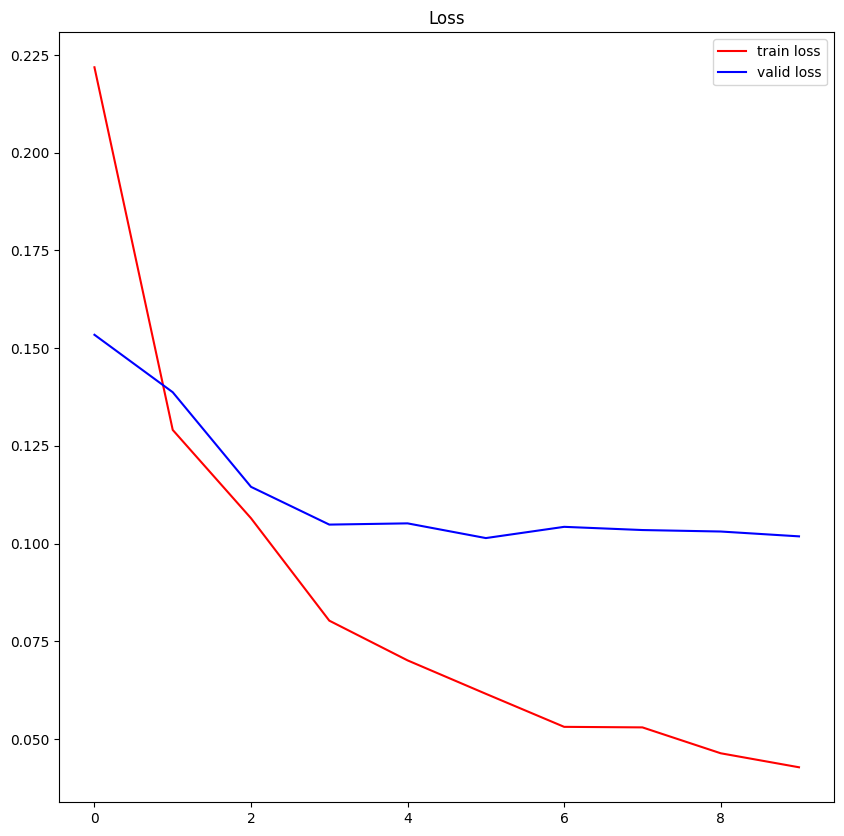

In [21]:
device = "cuda" if torch.cuda.is_available() else "cpu"

trainer = Semantic_Seg_Trainer(model=seg_model, 
                               opt="adam", 
                               lr=0.0001, 
                               has_scheduler=False, 
                               device=device).to(device)
start_time = time.time()
trainer.train(train_loader, 
              valid_loader, 
              max_epochs=10, 
              disp_epoch=1)

print(f"Training time : {time.time()-start_time:>3f}")

### Test

In [22]:
image = Image.open(os.path.join(root,'data/PennFudanPed/PNGImages/FudanPed00001.png'))
mask = Image.open(os.path.join(root,'data/PennFudanPed/PedMasks/FudanPed00001_mask.png'))

infer_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
])

input_image = infer_transform(image).to(device)

output = seg_model(input_image.unsqueeze(dim=0))
output['out'].shape

torch.Size([1, 2, 536, 559])

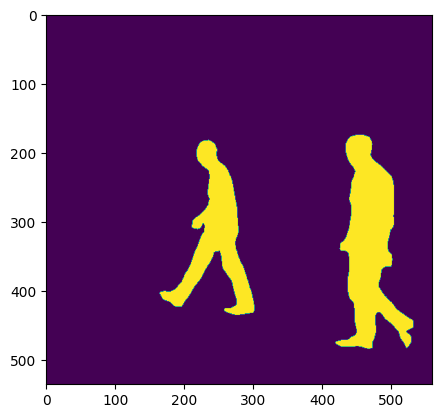

In [23]:
cls = torch.argmax(output['out'][0].to("cpu"), dim=0).numpy()

out = np.zeros_like(cls)
out[cls==1] = 1

plt.imshow(out);